### Task description: 
 
You’ve been tasked to implement a prototype of a component of a robotic depth perception system for human avoidance. The task is to find a distance between a human and a wall in a corridor using depth camera observations. Here is an example of a depth image (left) received from a depth camera mounted on a robot. The darker the pixel the closer it is; black corresponds to 0 meters and white corresponds to 5 meters. Just for reference, the corresponding RGB image is shown on the right. 

In [1]:
import pandas as pd
import numpy as np
import cv2
from matplotlib import pyplot as plt
from scipy import stats
%matplotlib inline 

In [17]:
def show_image(data):
    plt.imshow(data)
    plt.gray()
    plt.show()

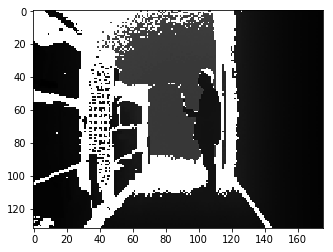

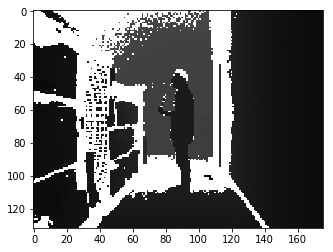

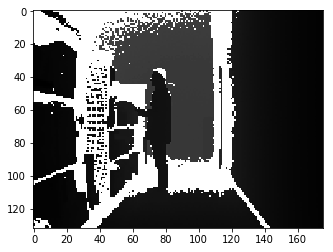

In [18]:
img0 = np.loadtxt("human_corridor_0.txt")
img1 = np.loadtxt("human_corridor_1.txt")
img2 = np.loadtxt("human_corridor_2.txt")
show_image(img0)
show_image(img1)
show_image(img2)

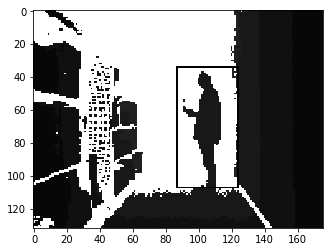

Left 0.9


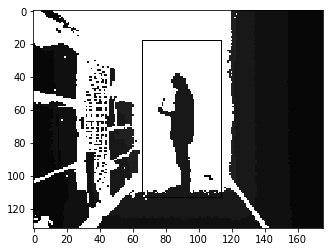

Left 0.771428571429


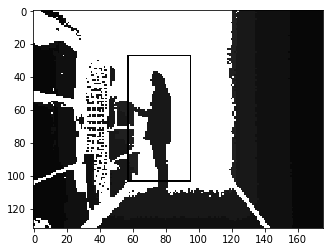

Right 0.848571428571


'Right 0.848571428571'

In [19]:
def getValidHumanRect(rects):
    """Finds valid human rects from array of rects."""
    rect = None
    for (x, y, w, h) in rects:
        # We are asumming that the human will be always between 40 and 140 pixels
        if x > 40 and (x + w) < 140:
            rect = (x, y, w, h)
    return rect
        
def getHumanRect(image):
    """This function returns rectangles that bind the detected humans by the HAAR classifier."""
    image_temp = image[:, :]
    # We will blur image using a 7 x 7 kernel
    image_temp = cv2.blur(image_temp, (7,7))
    # Person classifier initialized using trained cascadG.xml
    # Download cascade file from https://funvision.blogspot.com/2017/01/lbp-cascade-for-head-and-people.html
    person_cascade = cv2.CascadeClassifier('cascadG.xml')
    # Itentifying humans in the image
    rects = person_cascade.detectMultiScale(image_temp, minNeighbors=1)
    rect = getValidHumanRect(rects)
    return rect

def getWallShelfPixelAdjacentToHuman(image, rect):
    """ This function finds the index of pixel on wall and shelf, respectiely.
    The pixel is assumed to be approximately at the same height at human's center pixel"""
    (x, y, w, h) = rect
    x_center = int(x + w/2)
    human_depth_value = stats.mode(image[y: y + h, x_center])[0][0]
    y_center = int(y + h/2)
    # We will not search for pixel in human rectangle
    x_range = list(set(range(image.shape[1])) - set(range(x, x + w)))
    # Array to store shelf and wall pixels
    shelf_wall_pixels = []
    for b in x_range:
        # Getting the pixels on the wall and shelve in front and back of the humans
        if image[y_center][b] >= (human_depth_value - 2) and image[y_center][b] <= (human_depth_value + 2):
            shelf_wall_pixels.append(b)
            
    return min(shelf_wall_pixels), max(shelf_wall_pixels)

# # Function to compute the path to be taken
def get_next_path(depth):
    # Loading the Depth Image
    image = np.loadtxt(depth)
    # Thresholding the image values to eliminate noise, setting it to 5
    image[image > 5] = np.max(image)
    #image[image > np.mean(image)] = np.max(image)
    # Converting the Image to 8bit int format
    image = image.astype(np.uint8)
    rect = getHumanRect(image)
    pathFound = "Could not find path!"
    # Iterate through human rect # we should get only one human in our case.
    if rect is not None:
        (x, y, w, h) = rect
        # find center of human on X axis
        x_center = int(x + w/2)
        (shelf_pixel_idx, wall_pixel_idx) = getWallShelfPixelAdjacentToHuman(image, (x, y, w, h))
        
        # Corridor width in pixel
        pixel_width_corridor = wall_pixel_idx - shelf_pixel_idx
        # Given distance of human from camera in meters
        distance_human = 2
        # Given width of corridor in meters
        real_corridor_width = 1.5

        # Calculate focal length.
        focal_length = (distance_human * pixel_width_corridor) / real_corridor_width

        # Distance between wall and human(center) in pixels
        distance_wall_human_pixel = wall_pixel_idx - x_center
        
        # Distance of human from wall in meters
        distance_wall_human = (distance_human * distance_wall_human_pixel) / focal_length
        
        # Decide to go left or right!
        if(distance_wall_human > (real_corridor_width/2)):
            pathFound = 'Right ' + str(distance_wall_human)
        else:
            pathFound = 'Left ' + str(real_corridor_width - distance_wall_human)
        
        # Show the detected human
        cv2.rectangle(image, (x, y), (x + w, y + h), (0,255,0), 1)
    show_image(image)
    print(pathFound)
    return pathFound

get_next_path("human_corridor_0.txt")
get_next_path("human_corridor_1.txt")
get_next_path("human_corridor_2.txt")

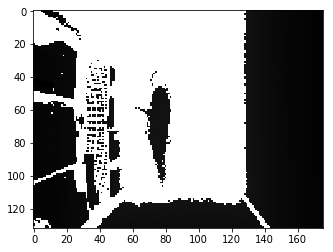

In [7]:
depth = "human_corridor_2.txt" 
image = np.loadtxt(depth)
image[image>np.median(image)] = 32
image = image*256/image.max()

show_image(image)